![](image/ONCFM_logo.PNG)

# <font size="5" style="color:#5D9B9B">Sommaire</font>


* [<font size="4" style="color:#5D9B9B">Importation des librairies</font>](#librairies)


* [<font size="4" style="color:#5D9B9B">1 - Importation et préparation des données</font>](#1)
    
    
* [<font size="4" style="color:#5D9B9B">2 - Simulation</font>](#2)
    * [<font size="3" style="color:#5D9B9B">Algorithme</font>](#21)
    * [<font size="3" style="color:#5D9B9B">Export des résultats</font>](#22)
    * [<font size="3" style="color:#5D9B9B">Analyse des résultats</font>](#23)

# <font size="7" style="color:#5D9B9B">Importation des librairies</font> <a class="anchor" id="librairies"></a>

In [1]:
import pandas as pd #dataframes
import numpy as np

from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn import decomposition

from sklearn.metrics import confusion_matrix
from sklearn import linear_model

In [2]:
pd.options.mode.chained_assignment = None  #Pour éviter les faux positifs sur SettingWithCopyWarning

# <font size="7" style="color:#5D9B9B">1 - Importation des données</font> <a class="anchor" id="1"></a>

In [3]:
#Vérification du nettoyage de données
import os

fait = ''

if os.path.exists('billets_prep.csv')==False:
    print("Finir Importation et préparation des données du notebook avant de continuer\n")
    fait = input('Fait ? (Oui/Non)\n')
else:
    print("Vous pouvez continuer")
        
if fait == 'Non':
    print("\nRevenir plus tard")
elif fait == 'Oui':
    print("\nVous pouvez continuer")
else:
    print("...")

Vous pouvez continuer
...


In [4]:
#Importation des données nettoyées sans le notebook
billets = pd.read_csv("billets_prep.csv", sep = ',')
billets.head(5) #Dataframe

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


# <font size="7" style="color:#5D9B9B">2 - Simulation</font> <a class="anchor" id="2"></a>

## <font size="6" style="color:#FBAA99">Algorithme</font> <a class="anchor" id="21"></a>

In [5]:
cluster_nb = int(input('Nombre de cluster = '))
seuil_veracite = float(input('Seuil de véracité (%) = '))
rep = int(input('Nombre de répétitions = '))
i = 1

nom_kmeans = np.array(["Essai", "precision_kmeans", "erreurs_kmeans", "fn_kmeans", "fp_kmeans", "sensibilite_kmeans", "specificite_kmeans"])
essaie_kmeans = pd.DataFrame(nom_kmeans)
essaie_kmeans.rename(columns={0: 'kmeans'}, inplace=True)

nom_log = np.array(["Essai", "precision_log", "erreurs_log", "fn_log", "fp_log", "sensibilite_log", "specificite_log"])
essaie_log = pd.DataFrame(nom_log)
essaie_log.rename(columns={0: 'regression_logistique'}, inplace=True)


while i <= rep : 
    #Division du dataframe
    billets_train = billets.sample(frac = 0.8)
    billets_test = billets.drop(billets_train.index).reset_index().iloc[:,1:] #Reset index pour correspondre aux clusters
    billets_train = billets_train.reset_index().iloc[:,1:]

    #On garde les variables pertinentes
    variables = billets_train.iloc[:,2:]
    variables.head()

    ########################################

    ##############
    ### Kmeans ###
    ##############

    #from sklearn.cluster import KMeans
    #from sklearn import preprocessing
    #from sklearn import decomposition

    # Nombre de clusters souhaités
    n_clust = cluster_nb

    # import de l'échantillon
    data = variables

    # préparation des données pour le clustering
    X = data.values

    # Réduire n'est ici pas nécessaire car les variables sont exprimées dans la même unité
    X_scaled = preprocessing.StandardScaler().fit_transform(X)

    # Clustering par K-means
    km = KMeans(n_clusters=n_clust)
    km.fit(X)

    # Récupération des clusters attribués à chaque individu
    clusters = km.labels_

    #Dataframe billets et clusters
    clusters = pd.DataFrame(data=km.labels_)
    clusters.rename(columns={0: 'cluster'}, inplace=True)

    billets_clusters = pd.merge(billets_train, clusters,
            left_index=True, right_index=True)

    #Nombre de billets vrais et faux dans chaque cluster
    billets_clusters_nb = billets_clusters.groupby(['cluster','is_genuine']).count().diagonal.reset_index()
    billets_clusters_nb.rename(columns={'diagonal': 'nombre'}, inplace=True)

    #Une ligne par cluster
    billets_clusters_conf = billets_clusters_nb.pivot(index='cluster', columns='is_genuine').reset_index()
    billets_clusters_conf = billets_clusters_conf.fillna(0)

    #Pourcentage de véracité du billet
    billets_clusters_conf_array = np.array(billets_clusters_conf)
    billets_clusters_conf = pd.DataFrame(data=billets_clusters_conf_array, columns=["cluster", "False", "True"])
    billets_clusters_conf['veracite'] = (billets_clusters_conf["True"]/(billets_clusters_conf["False"]+billets_clusters_conf["True"]))*100

    #On garde les variables utiles
    billets_clusters_conf = billets_clusters_conf[['cluster','veracite']]
    billets_clusters_conf['veracite'] = billets_clusters_conf['veracite'].round(2)

    #Importation
    billets_production = billets_test

    #Préparation
    billets_predict = billets_production.iloc[:,billets_production.columns.get_loc('height_left'):billets_production.columns.get_loc('length')+1]

    #Prediction des clusters
    closest_centroid = km.predict(np.array(billets_predict))

    #Dataframe pour les clusters
    billets_predict_cluster = pd.DataFrame(data=closest_centroid, columns=["cluster"])

    #Jointure avec le pourcentage de véracité du cluster
    resultats_kmeans = pd.merge(billets_predict_cluster, billets_clusters_conf,
            how='left', on='cluster')

    #Résultat avec seuil de véracité
    resultats_kmeans["resultat"] = resultats_kmeans['veracite']>seuil_veracite

    #Matrice de confusion
    
    #from sklearn.metrics import confusion_matrix

    y_true = billets_production['is_genuine']
    y_pred = resultats_kmeans['resultat']
    cm_kmeans = confusion_matrix(y_true, y_pred)


    #Erreurs
    fp_kmeans = cm_kmeans[0,1]
    fn_kmeans = cm_kmeans[1,0]
    erreurs_kmeans = fn_kmeans+fp_kmeans

    #sensibilité
    sensibilite_kmeans = cm_kmeans[1,1]/(cm_kmeans[1,1]+fn_kmeans)

    #spécificité
    specificite_kmeans = cm_kmeans[0,0]/(cm_kmeans[0,0]+fp_kmeans)

    #Précision
    sample = len(resultats_kmeans)
    precision_kmeans = 100-((erreurs_kmeans/sample)*100)

    ########################################
    
    #############################
    ### regression logistique ###
    #############################

    #from sklearn import linear_model

    #valeurs caractéristiques et valeur cible pour l'entraînement et le test
    x_train = billets_train.iloc[:,billets_train.columns.get_loc('height_left'):billets_train.columns.get_loc('length')+1]
    y_train = billets_train['is_genuine']

    x_test = billets_test.iloc[:,billets_test.columns.get_loc('height_left'):billets_train.columns.get_loc('length')+1]
    y_test = billets_test['is_genuine']

    #instanciation du modèle
    modele_regLog = linear_model.LogisticRegression(random_state = 0,
    solver = 'liblinear', multi_class = 'auto')

    #training
    modele_regLog.fit(x_train,y_train)

    #précision du modèle
    precision_log = modele_regLog.score(x_test,y_test)

    #Matrice de confusion
    y_true = y_test #is_genuine des données test
    y_pred = modele_regLog.predict(np.array(x_test)) #prédiction de is_genuine avec les données test
    cm_log = confusion_matrix(y_true, y_pred)


    #Erreurs
    fp_log = cm_log[0,1]
    fn_log = cm_log[1,0]
    erreurs_log = fn_log+fp_log

    #sensibilité
    sensibilite_log = cm_log[1,1]/(cm_log[1,1]+fn_log)

    #spécificité
    specificite_log = cm_log[0,0]/(cm_log[0,0]+fp_log)

    ########################################
    
    #################
    ### Résultats ###
    #################

    arr_kmeans = np.array([i, precision_kmeans, erreurs_kmeans, fn_kmeans, fp_kmeans, sensibilite_kmeans, specificite_kmeans])
    essaie_kmeans[i] = arr_kmeans
    
    arr_log = np.array([i, precision_log*100, erreurs_log, fn_log, fp_log, sensibilite_log, specificite_log])
    essaie_log[i] = arr_log    
    
    if i <= 5: #On affiche les 5 premiers
        methode_prec ="de la régression logistique"
        #Résultats k-means
        print("\n-----------------------"+str(i)+"-----------------------")
        print("\nLe modèle k-means est précis à "+str((precision_kmeans).round(2))+" % avec "+str(erreurs_kmeans)+" erreurs dont :")
        print("- "+str(fn_kmeans)+" faux négatifs")
        print("- "+str(fp_kmeans)+" faux positifs")
        print("La sensibilité est de "+str(sensibilite_kmeans.round(2)))
        print("La spécificité est de "+str(specificite_kmeans.round(2)))
        #Résultats Régression logistique
        print("\nLe modèle de la régression logistique est précis à "+str((precision_log*100).round(2))+" % avec "+str(erreurs_log)+" erreurs dont :")
        print("- "+str(fn_log)+" faux négatifs")
        print("- "+str(fp_log)+" faux positifs")
        print("La sensibilité est de "+str(sensibilite_log.round(2)))
        print("La spécificité est de "+str(specificite_log.round(2)))
    elif i == rep:
        print("\n----------------------- ..."+str(i)+"-----------------------")
    
    
    i = i + 1


print("\n----------------------- Moyenne k-means -----------------------")
essaie_kmeans_pivot = pd.pivot_table(essaie_kmeans, columns=['kmeans'])
kmeans_mean = essaie_kmeans_pivot.iloc[:,1:].mean(axis=0)
print (kmeans_mean)

print("\n----------------------- Moyenne regression logistique -----------------------")
essaie_log_pivot = pd.pivot_table(essaie_log, columns=['regression_logistique'])
log_mean = essaie_log_pivot.iloc[:,1:].mean(axis=0)
print (log_mean)

Nombre de cluster = 3
Seuil de véracité (%) = 95
Nombre de répétitions = 100

-----------------------1-----------------------

Le modèle k-means est précis à 99.0 % avec 3 erreurs dont :
- 1 faux négatifs
- 2 faux positifs
La sensibilité est de 0.99
La spécificité est de 0.98

Le modèle de la régression logistique est précis à 98.67 % avec 4 erreurs dont :
- 0 faux négatifs
- 4 faux positifs
La sensibilité est de 1.0
La spécificité est de 0.96

-----------------------2-----------------------

Le modèle k-means est précis à 98.33 % avec 5 erreurs dont :
- 1 faux négatifs
- 4 faux positifs
La sensibilité est de 0.99
La spécificité est de 0.96

Le modèle de la régression logistique est précis à 98.67 % avec 4 erreurs dont :
- 0 faux négatifs
- 4 faux positifs
La sensibilité est de 1.0
La spécificité est de 0.96

-----------------------3-----------------------

Le modèle k-means est précis à 99.67 % avec 1 erreurs dont :
- 0 faux négatifs
- 1 faux positifs
La sensibilité est de 1.0
La spéc

## <font size="6" style="color:#FBAA99">Export des résultats</font> <a class="anchor" id="22"></a>

In [6]:
kmeans_mean["rep"] = i-1
kmeans_mean["clusters"] = cluster_nb
kmeans_mean["seuil_veracite"] = seuil_veracite
kmeans_mean.to_csv(r'kmeans_mean.csv',index = True, header=True)

log_mean["rep"] = i-1
log_mean.to_csv(r'log_mean.csv',index = True, header=True)

## <font size="6" style="color:#FBAA99">Analyse des résultats</font> <a class="anchor" id="23"></a>

### Faux positifs

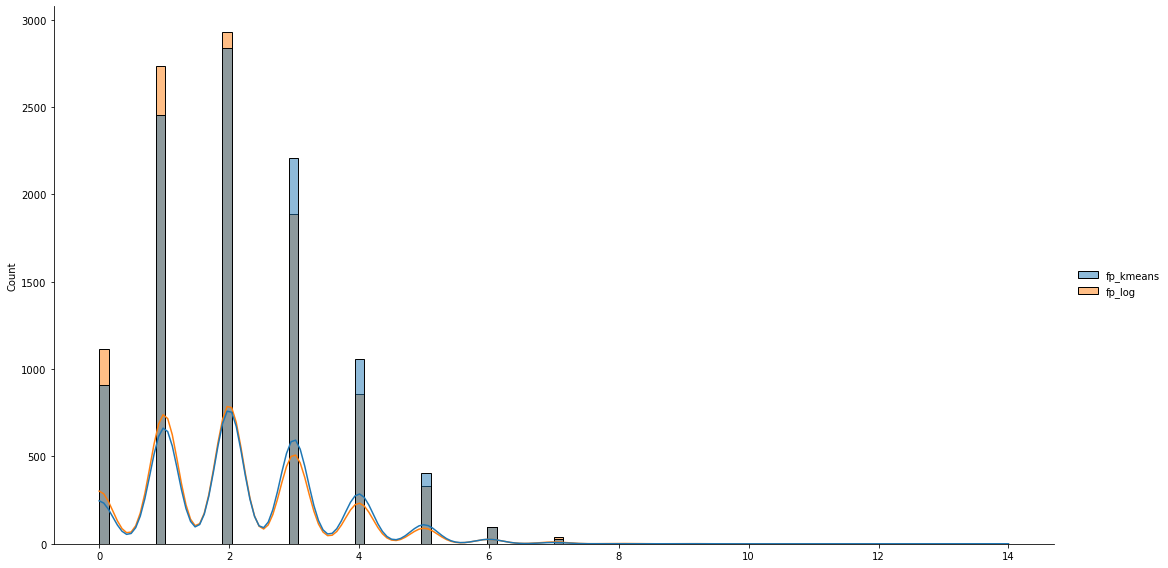

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

fp_graph = pd.merge(essaie_kmeans_pivot['fp_kmeans'], essaie_log_pivot['fp_log'],
        left_index=True, right_index=True)

sns.displot(fp_graph, kde=True ,height=8, aspect=15/8)
plt.show()

In [12]:
fp_graph.describe()

,fp_kmeans,fp_log
count,10000.000000,10000.000000
mean,2.182100,2.026300
std,1.358133,1.355652
min,0.000000,0.000000
25%,1.000000,1.000000
50%,2.000000,2.000000
75%,3.000000,3.000000
max,14.000000,9.000000


In [13]:
fp_graph.quantile([.8,.85,.90,.95,.96,.97,.98,.99,.999])

,fp_kmeans,fp_log
0.800,3.0,3.0
0.850,4.0,3.0
0.900,4.0,4.0
0.950,5.0,4.0
0.960,5.0,5.0
0.970,5.0,5.0
0.980,5.0,5.0
0.990,6.0,6.0
0.999,7.0,8.0


Seuil = 7


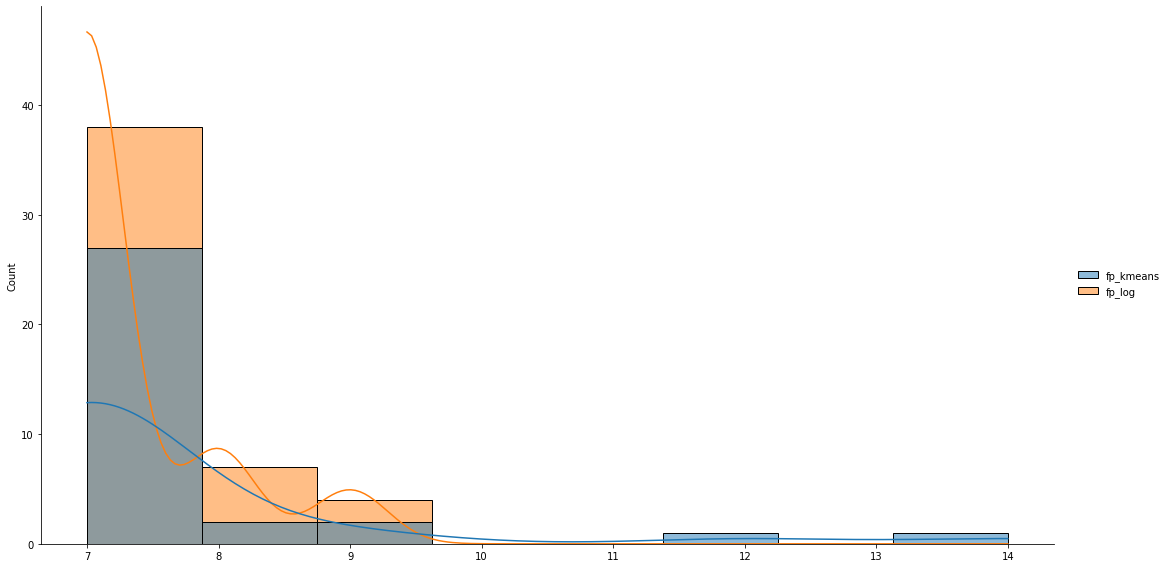

In [11]:
seuil = int(input('Seuil = '))
fp_graph_out = pd.concat([essaie_kmeans_pivot[essaie_kmeans_pivot['fp_kmeans']>=seuil].fp_kmeans, essaie_log_pivot[essaie_log_pivot['fp_log']>=seuil].fp_log], axis=1)

sns.displot(fp_graph_out, kde=True ,height=8, aspect=15/8)
plt.show()

### Comparaison par nombre de clusters

In [14]:
kmeans_mean_2 = pd.read_csv("simulation_10000/kmeans_mean_2.csv", sep = ',')
kmeans_mean_2.rename(columns={'0': 'moyenne'}, inplace=True)

kmeans_mean_3 = pd.read_csv("simulation_10000/kmeans_mean_3.csv", sep = ',')
kmeans_mean_3.rename(columns={'0': 'moyenne'}, inplace=True)

kmeans_mean_4 = pd.read_csv("simulation_10000/kmeans_mean_4.csv", sep = ',')
kmeans_mean_4.rename(columns={'0': 'moyenne'}, inplace=True)

rep = int(kmeans_mean_2.iat[6,1])

print("---- Résulat avec "+str(rep)+" essais ----\n")

clusters_sim_2 = int(kmeans_mean_2.iat[7,1])
seuil_vera_sim_2 = kmeans_mean_2.iat[8,1]
print("Clusters : "+str(clusters_sim_2)+"\nSeuil de veracité : "+str(seuil_vera_sim_2)+" %")
print(kmeans_mean_2)
print("--------\n")

clusters_sim_3 = int(kmeans_mean_3.iat[7,1])
seuil_vera_sim_3 = kmeans_mean_3.iat[8,1]
print("Clusters : "+str(clusters_sim_3)+"\nSeuil de veracité : "+str(seuil_vera_sim_3)+" %")
print(kmeans_mean_3)
print("--------\n")

clusters_sim_4 = int(kmeans_mean_4.iat[7,1])
seuil_vera_sim_4 = kmeans_mean_4.iat[8,1]
print("Clusters : "+str(clusters_sim_4)+"\nSeuil de veracité : "+str(seuil_vera_sim_4)+" %")
print(kmeans_mean_4)

---- Résulat avec 10000 essais ----

Clusters : 2
Seuil de veracité : 95.0 %
               kmeans       moyenne
0      erreurs_kmeans      4.955900
1           fn_kmeans      0.487000
2           fp_kmeans      4.468900
3    precision_kmeans     98.348033
4  sensibilite_kmeans      0.997566
5  specificite_kmeans      0.955226
6                 rep  10000.000000
7            clusters      2.000000
8      seuil_veracite     95.000000
--------

Clusters : 3
Seuil de veracité : 95.0 %
               kmeans       moyenne
0      erreurs_kmeans      4.450100
1           fn_kmeans      2.268000
2           fp_kmeans      2.182100
3    precision_kmeans     98.516633
4  sensibilite_kmeans      0.988592
5  specificite_kmeans      0.978141
6                 rep  10000.000000
7            clusters      3.000000
8      seuil_veracite     95.000000
--------

Clusters : 4
Seuil de veracité : 95.0 %
               kmeans       moyenne
0      erreurs_kmeans     25.436500
1           fn_kmeans     22.02

##### Le nombre de clusters idéal est 3 avec une meilleure précision et spécificité